<a href="https://colab.research.google.com/github/shubhamraut0209/Quantium-Data-Analytics-Simulation/blob/main/Quantium_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task-2:- Experimentation and uplift testing**

In [ ]:
install.packages("ggmosaic")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#### Load required libraries
library(data.table)
library(ggplot2)
library(ggmosaic)
library(readr)

In [ ]:
# Load required libraries and datasets
data= read.csv("/content/QVI_data (1).csv")

In [ ]:
head(data,5)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
2,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
3,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
4,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
5,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [ ]:
#### Set themes for plots
theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))

***Select control stores***  
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.  

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :  
• Monthly overall sales revenue  
• Monthly number of customers  
• Monthly number of transactions per customer  

Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [ ]:
#### Calculate these measures over time for each store
#### Create a month ID
library(data.table)
setDT(data)
data[, YEARMONTH := year(DATE)*100 + month(DATE)]

In [ ]:
#### Define the measure calculations
measureOverTime= data[, .(totSales = sum(TOT_SALES),
nCustomers = uniqueN(LYLTY_CARD_NBR),
nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)
), by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

In [ ]:
#### Filter to the pre‐trial period and stores with full observation periods
storesWithFullObs= unique(measureOverTime[, .N, STORE_NBR][N == 12, STORE_NBR])
preTrialMeasures= measureOverTime[YEARMONTH < 201902 & STORE_NBR %in% storesWithFullObs, ]

In [ ]:
# Now we need to work out a way of ranking how similar each potential control store is to the trial store.

# We can calculate how correlated the performance of each store is to the trial store.
# Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [ ]:
#### Create a function to calculate correlation for a measure,
#### looping through each control store
calculateCorrelation= function(inputTable, metricCol, storeComparison) {
calcCorrTable = data.table(Store1 = numeric(), Store2 = numeric(), corr_measure = numeric())
storeNumbers= unique(inputTable[, STORE_NBR])
for (i in storeNumbers) {
calculatedMeasure = data.table("Store1" = storeComparison, "Store2" = i,
"corr_measure" = cor(inputTable[STORE_NBR == storeComparison,
eval(metricCol)], inputTable[STORE_NBR == i, eval(metricCol)]))
calcCorrTable= rbind(calcCorrTable, calculatedMeasure)
}
return(calcCorrTable)
}

In [ ]:
# Apart from correlation,
# we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance

In [ ]:
#### Create a function to calculate a standardised magnitude distance for a measure,
#### looping through each control store
calculateMagnitudeDistance= function(inputTable, metricCol, storeComparison) {
calcDistTable = data.table(Store1 = numeric(), Store2 = numeric(), YEARMONTH = numeric(), measure = numeric())
storeNumbers= unique(inputTable[, STORE_NBR])
for (i in storeNumbers) {
calculatedMeasure= data.table("Store1" = storeComparison, "Store2" = i, "YEARMONTH" = inputTable[STORE_NBR == storeComparison, YEARMONTH]
, "measure" = abs(inputTable[STORE_NBR == storeComparison, eval(metricCol)] - inputTable[STORE_NBR == i, eval(metricCol)])
)
calcDistTable= rbind(calcDistTable, calculatedMeasure)
}
#### Standardise the magnitude distance so that the measure ranges from 0 to 1
minMaxDist= calcDistTable[, .(minDist = min(measure), maxDist = max(measure)), by = c("Store1", "YEARMONTH")]
distTable= merge(calcDistTable, minMaxDist, by = c("Store1", "YEARMONTH"))
distTable[, magnitudeMeasure := 1 - (measure - minDist)/(maxDist - minDist)]
finalDistTable= distTable[, .(mag_measure = mean(magnitudeMeasure)), by = .(Store1, Store2)]
return(finalDistTable)
}

In [ ]:
# We’ll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores.
# So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [ ]:
#### Use the functions for calculating correlation
trial_store= 77
corr_nSales= calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers= calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
#### Use the functions for calculating magnitude
magnitude_nSales= calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers= calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
# We’ll need to combine the all the scores calculated using our function to create a composite score to rank on.
# Let’s take a simple average of the correlation and magnitude scores for each driver.

In [ ]:
#### Create a combined score composed of correlation and magnitude
corr_weight= 0.5
score_nSales= merge(corr_nSales, magnitude_nSales, by = c("Store1","Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]
score_nCustomers= merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]

In [ ]:
# Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average

In [ ]:
#### Combine scores across the drivers
score_Control= merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

In [ ]:
# The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [ ]:
#### Select control stores based on the highest matching store
control_store= score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store

[1] 233

In [ ]:
# Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial.

In [ ]:
# We’ll look at total sales first.

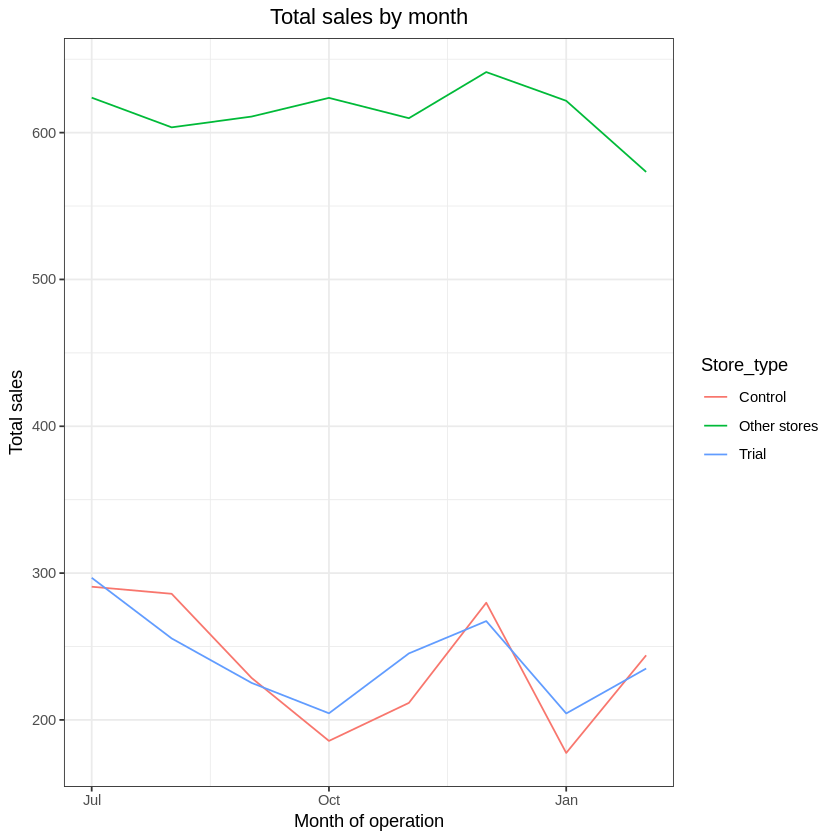

In [ ]:
#### Visual checks on trends based on the drivers
measureOverTimeSales= measureOverTime
pastSales= measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
geom_line() +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [ ]:
# Next,
# number of customers

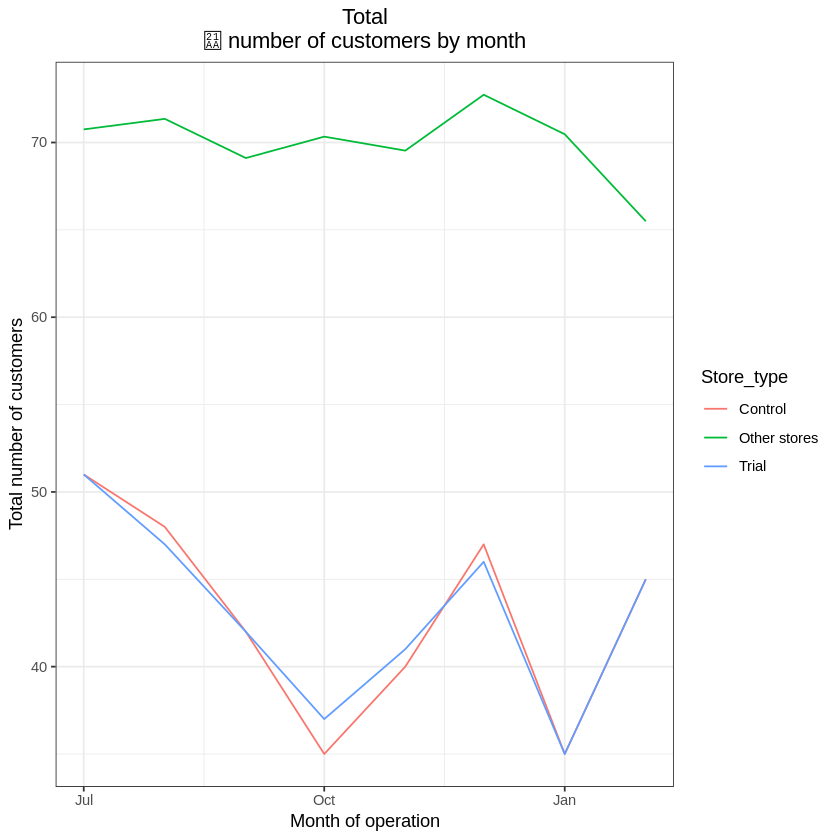

In [ ]:
#### Visual checks on trends based on the drivers
measureOverTimeCusts= measureOverTime
pastCustomers= measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) +
geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

***Assessment of trial***

In [ ]:
# The trial period goes from the start of March 2019 to June 2019.
# We now want to see if there has been an uplift in overall chip sales.

In [ ]:
# We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

In [ ]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
scalingFactorForControlSales= preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(totSales)]

In [ ]:
#### Apply the scaling factor
measureOverTimeSales= measureOverTime
scaledControlSales= measureOverTimeSales[STORE_NBR == control_store, ][ , controlSales := totSales * scalingFactorForControlSales]

In [ ]:
# Now that we have comparable sales figures for the control store,
# we can calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff= merge(scaledControlSales[, c("YEARMONTH", "controlSales")], measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],
by = "YEARMONTH")[, percentageDiff := abs(controlSales-totSales)/controlSales]

In [ ]:
# Let’s see if the difference is significant!

In [ ]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev= sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

In [ ]:
#### note that there are 8 months in the pre‐trial period
#### hence 8 ‐ 1 = 7 degrees of freedom
degreesOfFreedom= 7

In [ ]:
#### We will test with a null hypothesis of there being 0 difference between trial and control stores
percentageDiff[, tValue := (percentageDiff - 0)/stdDev
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201905 & YEARMONTH > 201901, .(TransactionMonth, tValue)]

TransactionMonth,tValue
<date>,<dbl>
2019-02-01,1.183534
2019-03-01,7.339116
2019-04-01,12.476373


In [ ]:
#### Find the 95th percentile of the t distribution with the appropriate degrees of freedom to compare against
qt(0.95, df = degreesOfFreedom)

[1] 1.894579

In [ ]:
# We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April
# i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

In [ ]:
# Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
# and the 95th percentile value of sales of the control store.

In [ ]:
measureOverTimeSales= measureOverTime

#### Trial and control store total sales
pastSales= measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][Store_type %in% c("Trial", "Control"), ]

In [ ]:
#### Control store 95th percentile
pastSales_Controls95= pastSales[Store_type == "Control", ][, totSales := totSales * (1 + stdDev * 2)][, Store_type := "Control 95th % confidence interval"]

In [ ]:
#### Control store 5th percentile
pastSales_Controls5= pastSales[Store_type == "Control", ][, totSales := totSales * (1 - stdDev * 2)][, Store_type := "Control 5th % confidence interval"]
trialAssessment= rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

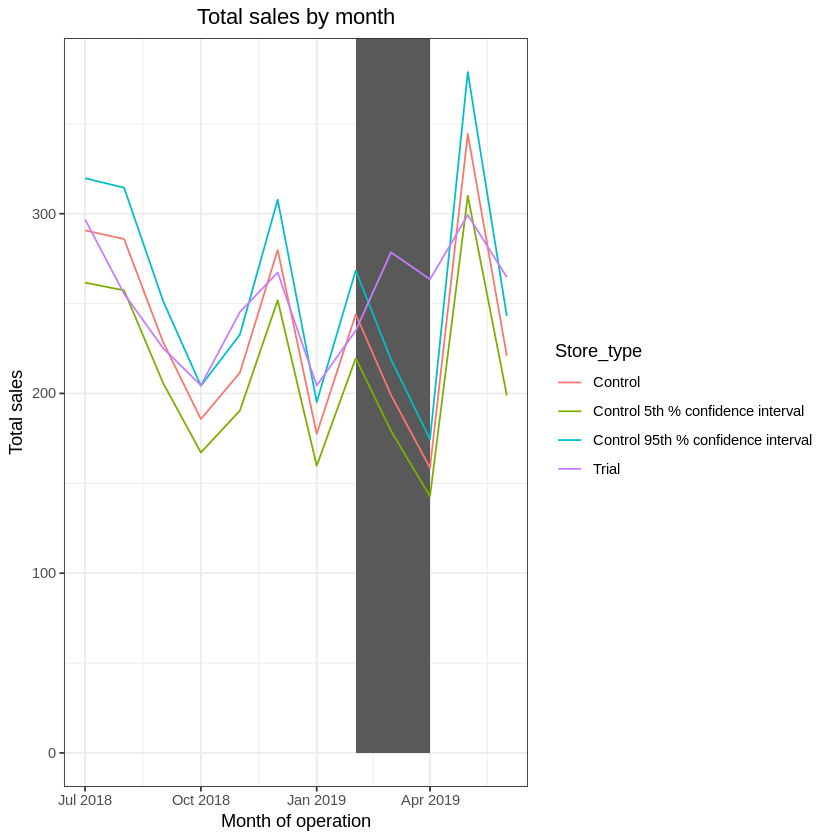

In [ ]:
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) +
geom_line() +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [ ]:
# The results show that the trial in store 77 is significantly different to its control store in the trial period,
# as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [ ]:
# Let’s have a look at assessing this for number of customers as well.

In [ ]:
#### Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust= preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(nCustomers)]

In [ ]:
#### Apply the scaling factor
measureOverTimeCusts= measureOverTime
scaledControlCustomers= measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
]

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff= merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],measureOverTimeCusts[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],
by = "YEARMONTH")[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

In [ ]:
# Let’s again see if the difference is significant visually!

In [ ]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, let's take the standard deviation based on the
# scaled percentage difference in the pre‐trial period
stdDev= sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom = 7

In [ ]:
#### Trial and control store number of customers
pastCustomers= measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")][Store_type %in% c("Trial", "Control"), ]

In [ ]:
#### Control store 95th percentile
pastCustomers_Controls95= pastCustomers[Store_type == "Control", ][, nCusts := nCusts * (1 + stdDev * 2)][, Store_type := "Control 95th % confidence interval"]

In [ ]:
#### Control store 5th percentile
pastCustomers_Controls5= pastCustomers[Store_type == "Control", ][, nCusts := nCusts * (1 - stdDev * 2)][, Store_type := "Control 5th % confidence interval"]
trialAssessment= rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

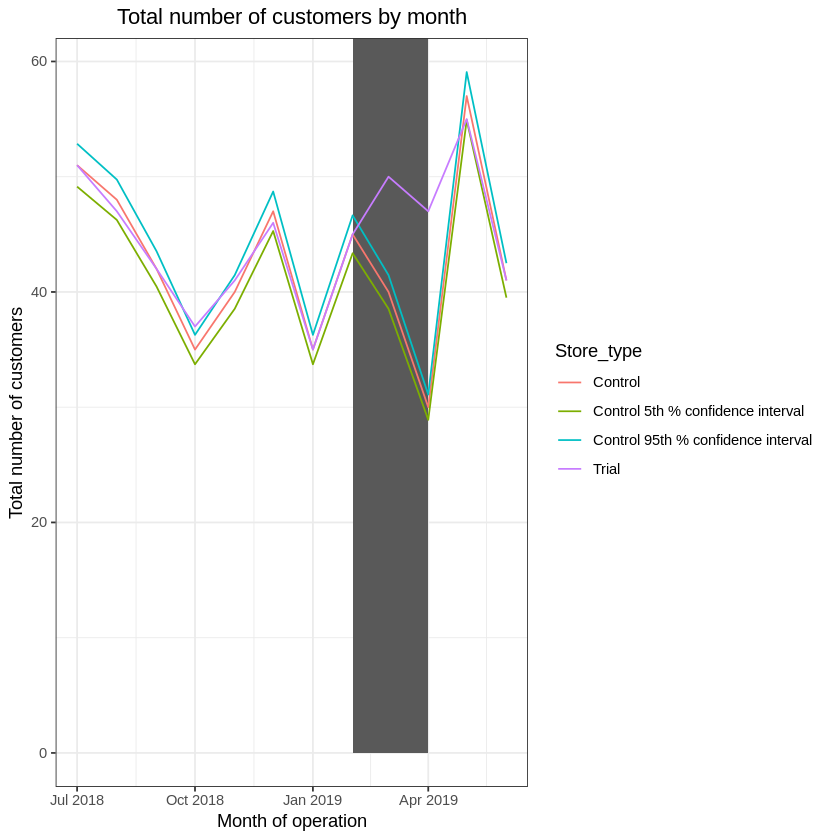

In [ ]:
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) +
geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [ ]:
# Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.

For Trial store 86

In [ ]:
measureOverTime= data[, .(totSales = sum(TOT_SALES), nCustomers = uniqueN(LYLTY_CARD_NBR), nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID), avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)), by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

In [ ]:
#### Use the functions for calculating correlation
trial_store= 86
corr_nSales= calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers= calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
#### Use the functions for calculating magnitude
magnitude_nSales= calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers= calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
#### Create a combined score composed of correlation and magnitude
corr_weight= 0.5
score_nSales= merge(corr_nSales, magnitude_nSales, by = c("Store1","Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1-corr_weight)]
score_nCustomers= merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]

In [ ]:
#### Combine scores across the drivers
score_Control= merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

In [ ]:
#### Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)
#### Select control store for trial store 86
control_store= score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store

[1] 155

In [ ]:
# Looks like store 155 will be a control store for trial store 86.

In [ ]:
# Again, let’s check visually if the drivers are indeed similar in the period before the trial.
# We’ll look at total sales first.

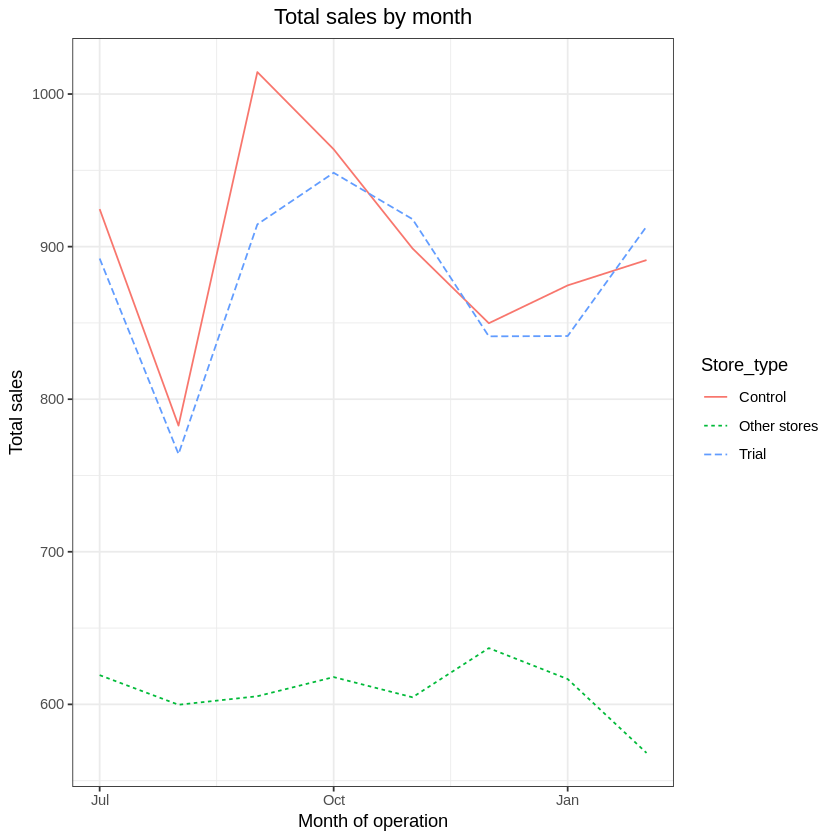

In [ ]:
#### Visual checks on trends based on the drivers
measureOverTimeSales= measureOverTime
pastSales= measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [ ]:
# Great
# sales are trending in a similar way.

In [ ]:
# Next,
# number of customers

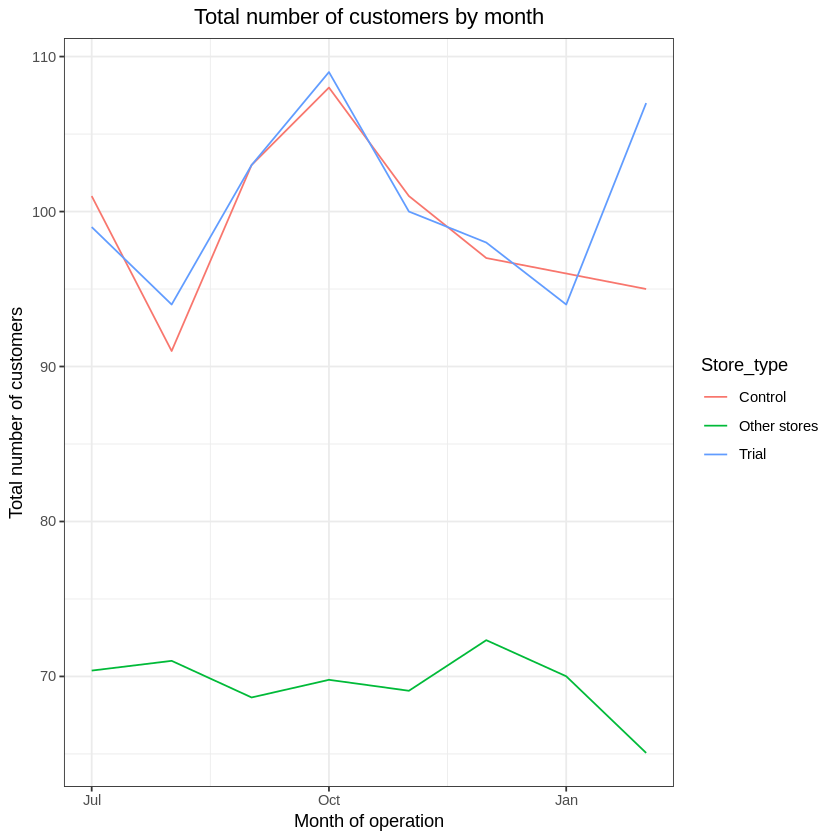

In [ ]:
#### Visual checks on trends based on the drivers
measureOverTimeCusts= measureOverTime
pastCustomers= measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) +
geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [ ]:
# Good, the trend in number of customers is also similar.

In [ ]:
# Let’s now assess the impact of the trial on sales.

In [ ]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
scalingFactorForControlSales= preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(totSales)]

In [ ]:
#### Apply the scaling factor
measureOverTimeSales= measureOverTime
scaledControlSales= measureOverTimeSales[STORE_NBR == control_store, ][ , controlSales := totSales * scalingFactorForControlSales]

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff= merge(scaledControlSales[, c("YEARMONTH", "controlSales")], measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],
by = "YEARMONTH"
)[, percentageDiff := abs(controlSales-totSales)/controlSales]

In [ ]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev= sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

In [ ]:
degreesOfFreedom= 7

#### Trial and control store total sales
measureOverTimeSales= measureOverTime
pastSales= measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][Store_type %in% c("Trial", "Control"), ]

In [ ]:
#### Control store 95th percentile
pastSales_Controls95= pastSales[Store_type == "Control",
][, totSales := totSales * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

In [ ]:
#### Control store 5th percentile
pastSales_Controls5= pastSales[Store_type == "Control",
][, totSales := totSales * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]

trialAssessment= rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

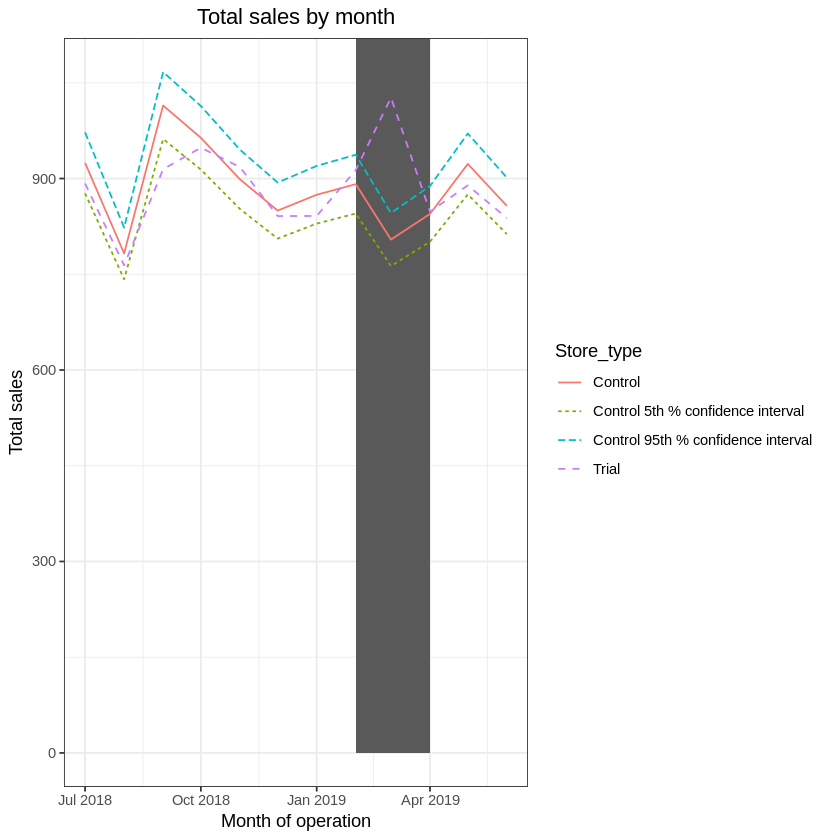

In [ ]:
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) +
geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [ ]:
# The results show that the trial in store 86 is not significantly different to its control store in the trial period
# as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [ ]:
# Let’s have a look at assessing this for number of customers as well.

In [ ]:
#### Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust= preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(nCustomers)]

In [ ]:
#### Apply the scaling factor
measureOverTimeCusts= measureOverTime
scaledControlCustomers= measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
]

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff= merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],
measureOverTime[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],
by = "YEARMONTH"
)[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

In [ ]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev= sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

In [ ]:
degreesOfFreedom= 7
#### Trial and control store number of customers
pastCustomers= measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][Store_type %in% c("Trial", "Control"), ]

In [ ]:
#### Control store 95th percentile
pastCustomers_Controls95= pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

In [ ]:
#### Control store 5th percentile
pastCustomers_Controls5= pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]
trialAssessment= rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

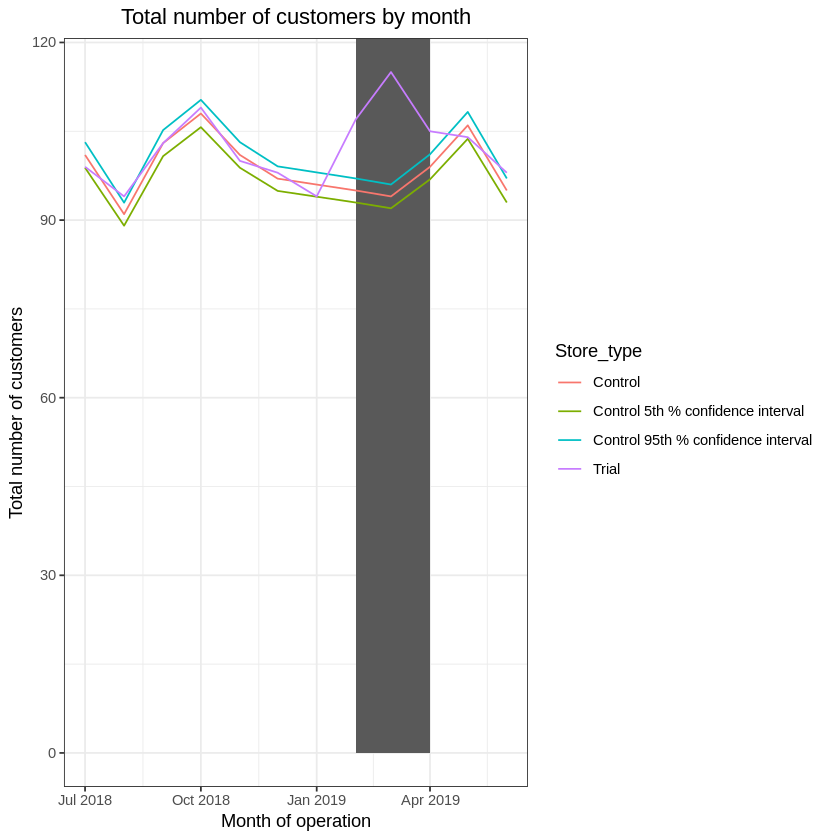

In [ ]:
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) +
geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [ ]:
# It looks like the number of customers is significantly higher in all of the three months.
# This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw,
# sales were not significantly higher.

In [ ]:
#  We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

For Trial store 88

In [ ]:
measureOverTime= data[, .(totSales = sum(TOT_SALES), nCustomers = uniqueN(LYLTY_CARD_NBR), nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID), avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)
)
, by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

In [ ]:
#### Use the functions for calculating correlation
trial_store= 88
corr_nSales= calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers= calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
#### Use the functions for calculating magnitude
magnitude_nSales= calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers= calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [ ]:
#### Create a combined score composed of correlation and magnitude
corr_weight= 0.5
score_nSales= merge(corr_nSales, magnitude_nSales, by = c("Store1","Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1-corr_weight)]
score_nCustomers= merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1- corr_weight)]

In [ ]:
#### Combine scores across the drivers
score_Control= merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

In [ ]:
#### Select control stores based on the highest matching store(closest to 1 but not the store itself, i.e. the second ranked highest store)
#### Select control store for trial store 88
control_store= score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store

[1] 237

In [ ]:
# We’ve now found store 237 to be a suitable control store for trial store 88.

In [ ]:
# Again, let’s check visually if the drivers are indeed similar in the period before the trial.

In [ ]:
# We’ll look at total sales first.

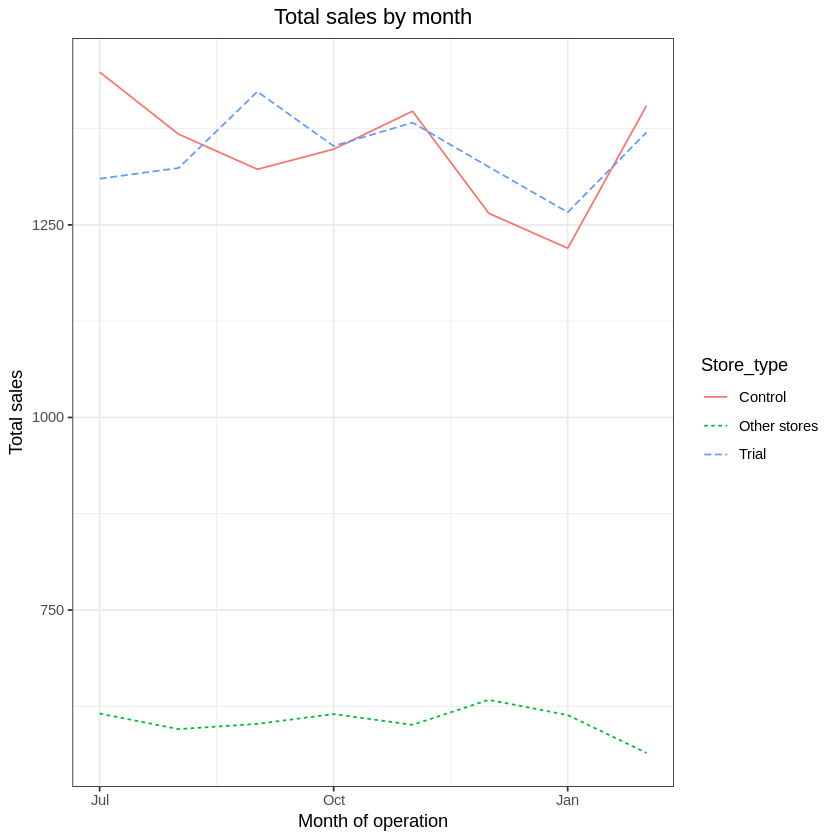

In [ ]:
#### Visual checks on trends based on the drivers
measureOverTimeSales= measureOverTime
pastSales= measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [ ]:
# Great,
# the trial and control stores have similar total sales.

In [ ]:
# Next,
# number of customers.

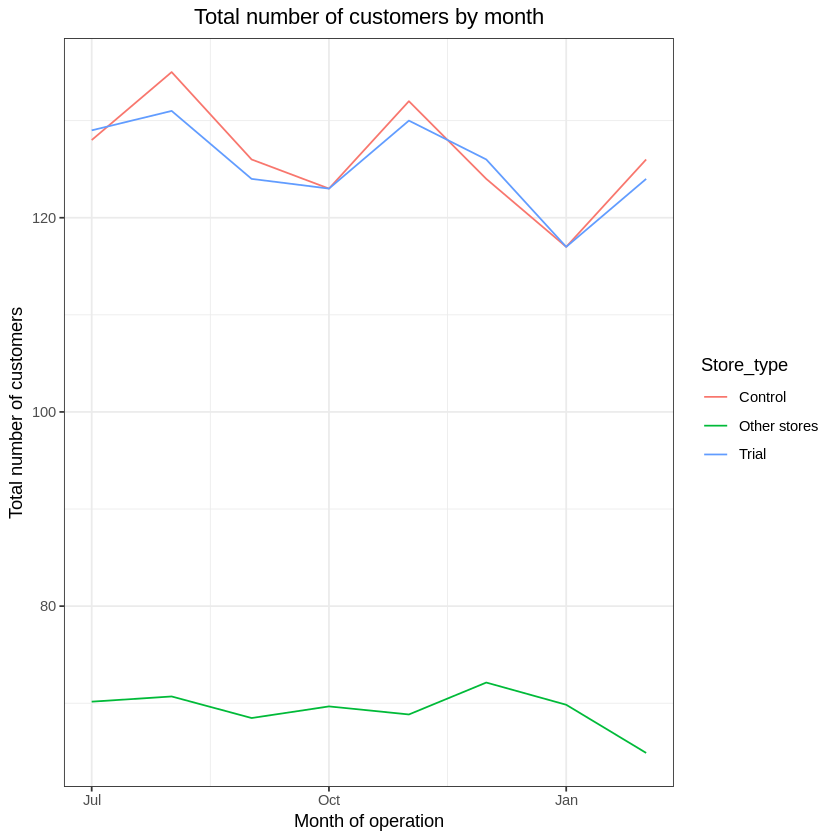

In [ ]:
#### Visual checks on trends based on the drivers
measureOverTimeCusts= measureOverTime
pastCustomers= measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) +
geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [ ]:
# Total number of customers of the control and trial stores are also similar.

In [ ]:
# Let’s now assess the impact of the trial on sales.

In [ ]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
scalingFactorForControlSales= preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(totSales)]

In [ ]:
#### Apply the scaling factor
measureOverTimeSales= measureOverTime
scaledControlSales= measureOverTimeSales[STORE_NBR == control_store, ][ , controlSales := totSales * scalingFactorForControlSales]

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff= merge(scaledControlSales[, c("YEARMONTH", "controlSales")], measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],
by = "YEARMONTH"
)[, percentageDiff := abs(controlSales-totSales)/controlSales]

In [ ]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev= sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

In [ ]:
degreesOfFreedom= 7
#### Trial and control store total sales
measureOverTimeSales= measureOverTime
pastSales= measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][Store_type %in% c("Trial", "Control"), ]

In [ ]:
#### Control store 95th percentile
pastSales_Controls95= pastSales[Store_type == "Control",
][, totSales := totSales * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

In [ ]:
#### Control store 5th percentile
pastSales_Controls5= pastSales[Store_type == "Control",
][, totSales := totSales * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]

trialAssessment= rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

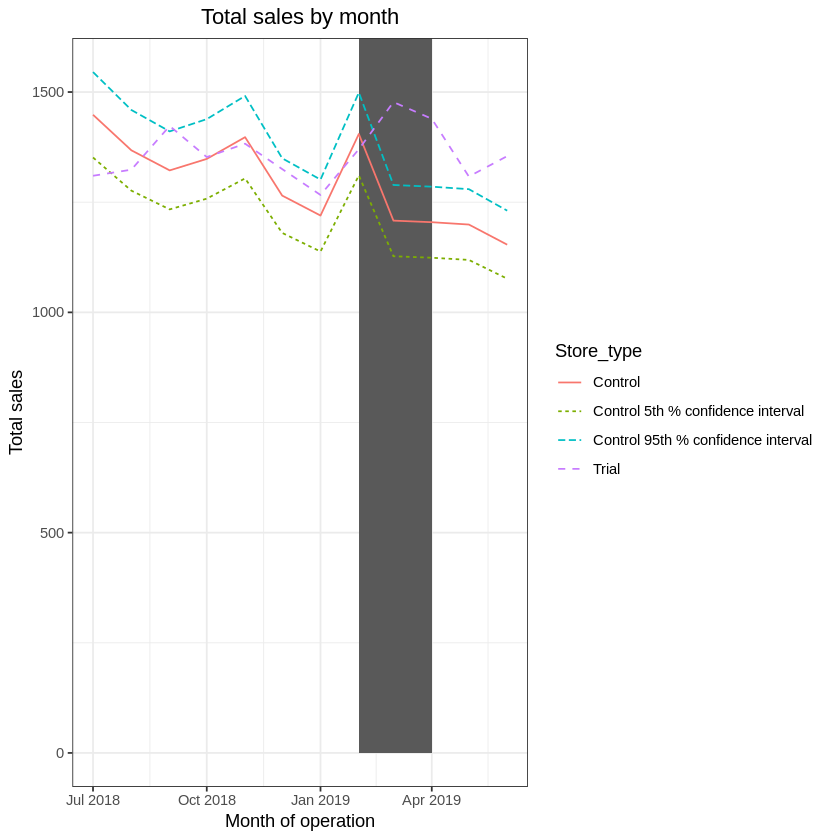

In [ ]:
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) +
geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [ ]:
# The results show that the trial in store 88 is significantly different to its control store in the trial period,
# as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

In [ ]:
# Let’s have a look at assessing this for number of customers as well.

In [ ]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust= preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(nCustomers)]

In [ ]:
#### Apply the scaling factor
measureOverTimeCusts= measureOverTime
scaledControlCustomers= measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
]

In [ ]:
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff= merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")], measureOverTime[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],
by = "YEARMONTH"
)[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

In [ ]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period
stdDev= sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

In [ ]:
degreesOfFreedom= 7 # note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
#### Trial and control store number of customers
pastCustomers= measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][Store_type %in% c("Trial", "Control"), ]

In [ ]:
#### Control store 95th percentile
pastCustomers_Controls95= pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

In [ ]:
#### Control store 5th percentile
pastCustomers_Controls5= pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]

trialAssessment= rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

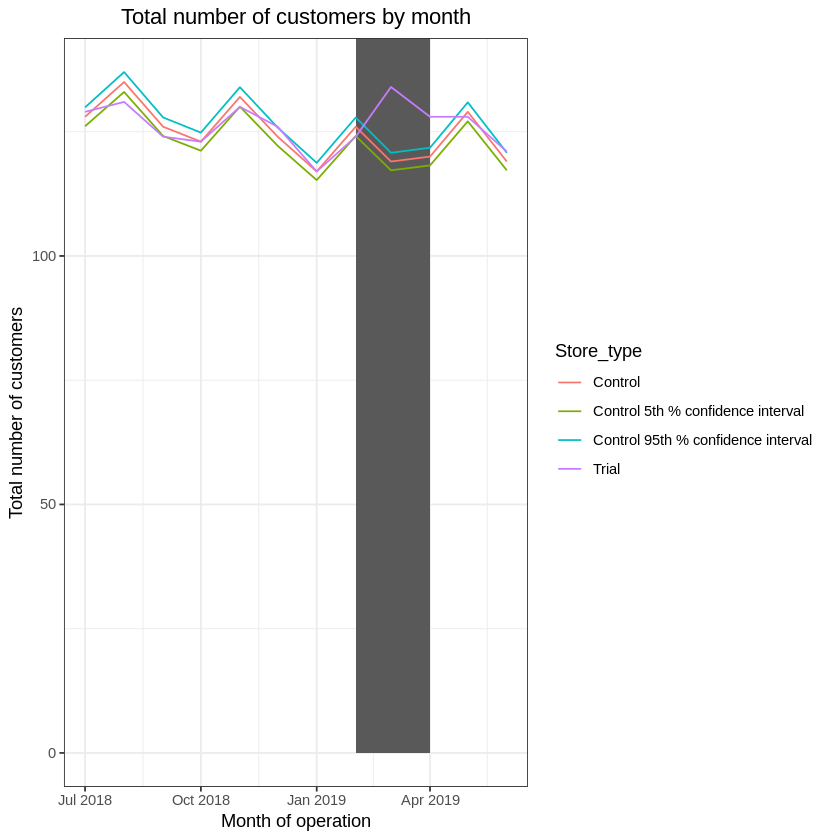

In [ ]:
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) +
geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [ ]:
# Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months,
# which indicates a positive trial effect

***Conclusion***

In [ ]:
# We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

In [ ]:
# The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months,
# but this is not the case for trial store 86.
# We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.